In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
# X_test = X_test.astype('float32') / 255

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

print('Training data shape:', X_train.shape)    # Should be (50000, 32, 32, 3)
print('Training labels shape:', y_train.shape)  # Should be (50000, 10)
# print('Test data shape:', X_test.shape)         # Should be (10000, 32, 32, 3)
# print('Test labels shape:', y_test.shape)       # Should be (10000, 10)

Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000, 10)


In [3]:
model = Sequential([
    keras.Input(shape=(32, 32, 3)),

    # First layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),

    # Max pooling layer
    MaxPool2D(pool_size=(2, 2), strides=2),

    # Second layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),

    # Max pooling layer
    MaxPool2D(pool_size=(2, 2), strides=2),

    # Third layer
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    
    # Flatten layer
    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # Dropout layer
    keras.layers.Dropout(0.5),

    # Output layer
    Dense(10, activation='softmax')
])


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,226 (8.37 MB)

 Trainable params: 2,193,226 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
    callbacks=[early_stopping]
)

# Add the plotting code
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.0879 - loss: 2.9416   

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.2698 - loss: 2.0992 - val_accuracy: 0.4103 - val_loss: 1.7478
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4191 - loss: 1.7107 - val_accuracy: 0.5119 - val_loss: 1.4603
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.4670 - loss: 1.6121 - val_accuracy: 0.5406 - val_loss: 1.4063
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.4945 - loss: 1.5459 - val_accuracy: 0.5517 - val_loss: 1.3766
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.5231 - loss: 1.4940 - val_accuracy: 0.5821 - val_loss: 1.3318
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.5359 - loss: 1.4670 - val_accuracy: 0.5811 - val_loss: 1.3186
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5514 - loss: 1.4384 - val_accuracy: 0.6192 - val_loss: 1.2686
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.5676 - loss: 1.39

KeyboardInterrupt: 

# Test data

In [14]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_batch = unpickle('cifar-10-batches-py/test_batch')
X = test_batch[b'data']
y_true = test_batch[b'labels']

X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0

y_true_categorical = keras.utils.to_categorical(y_true, num_classes=10)

test_loss, test_accuracy = model.evaluate(X, y_true_categorical, verbose=1)
print(f'\nTest accuracy: {test_accuracy:.4f}')

predictions = model.predict(X)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_true, predicted_classes)
print('\nConfusion Matrix:')
print(cm)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7364 - loss: 1.0598

Test accuracy: 0.7363
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Confusion Matrix:
[[741  14  71  29  22   5   9  17  58  34]
 [ 10 860  11   6   4   3   7   5  23  71]
 [ 54   2 608  54  90  75  65  37   7   8]
 [ 11   3  81 531  57 195  62  39  10  11]
 [ 20   3  74  53 654  36  48 102   8   2]
 [  7   0  48 144  41 667  19  63   2   9]
 [  5   3  48  54  30  23 822  12   2   1]
 [ 10   3  38  34  30  60   3 816   2   4]
 [ 58  27  13  25   8   4   4   7 831  23]
 [ 25  68   7  20   5   8   3  11  20 833]]


# Plot confusion matrix

Confusion matrix, without normalization
[[741  14  71  29  22   5   9  17  58  34]
 [ 10 860  11   6   4   3   7   5  23  71]
 [ 54   2 608  54  90  75  65  37   7   8]
 [ 11   3  81 531  57 195  62  39  10  11]
 [ 20   3  74  53 654  36  48 102   8   2]
 [  7   0  48 144  41 667  19  63   2   9]
 [  5   3  48  54  30  23 822  12   2   1]
 [ 10   3  38  34  30  60   3 816   2   4]
 [ 58  27  13  25   8   4   4   7 831  23]
 [ 25  68   7  20   5   8   3  11  20 833]]


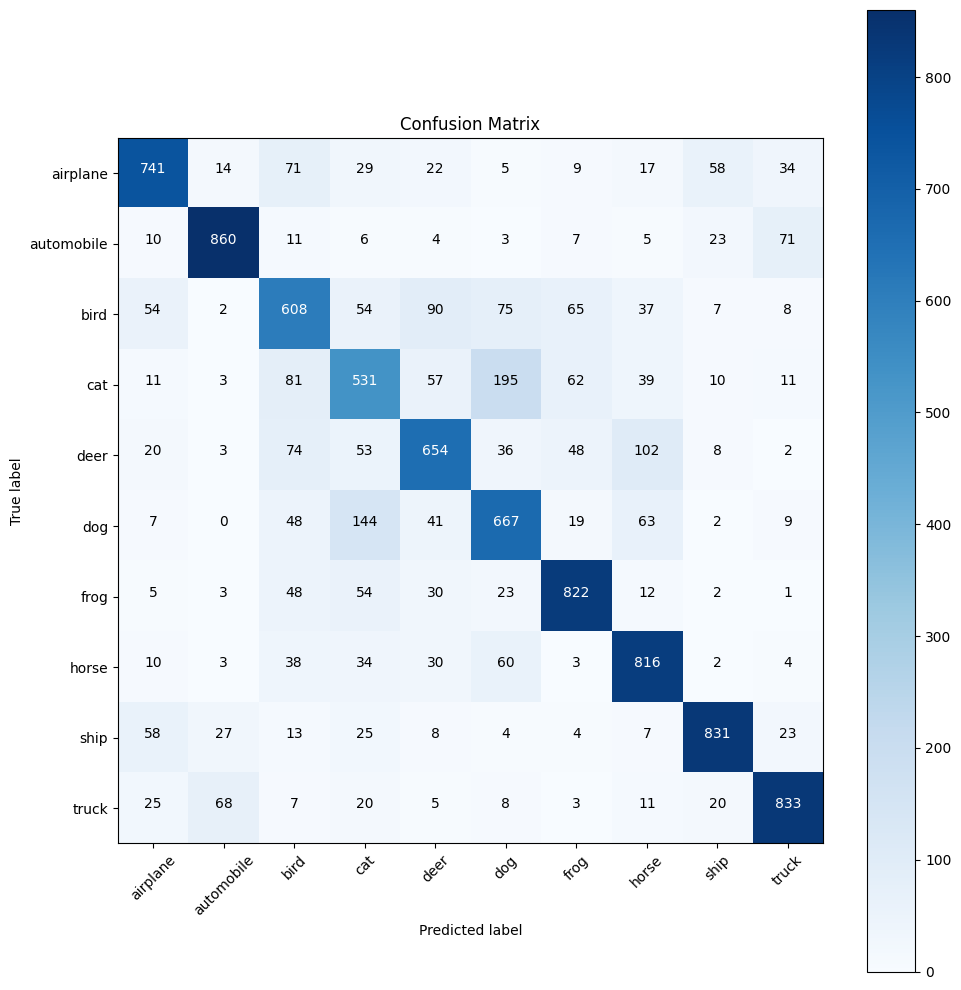

In [15]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm,  # confusion matrix we calculated earlier
                     classes=class_names,
                     normalize=False,  # set to True if you want percentages
                     title='Confusion Matrix')

plt.show()

# Save the model

In [16]:
model.save('models/model4.keras')